# Prompts

**Structured Prompts**:
- Frameworks like RSTCC, RICCE, etc.

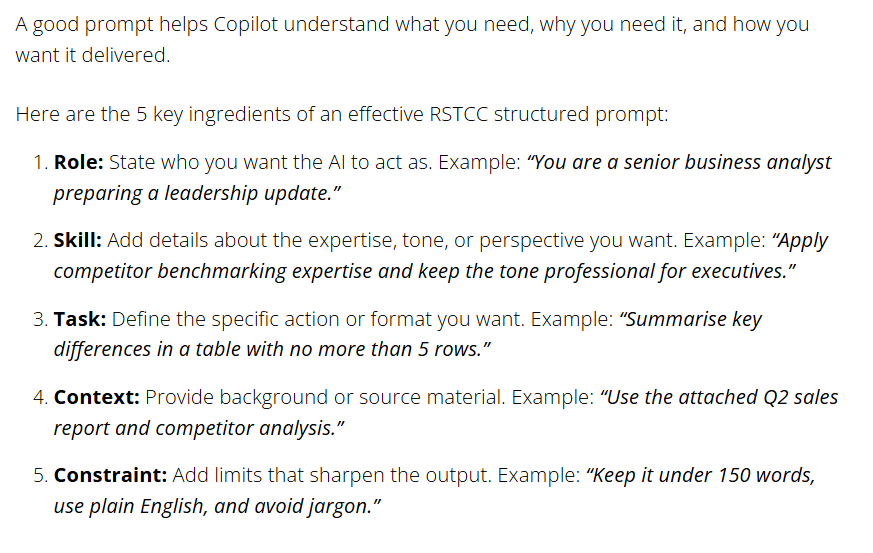


# Transformer from scratch

In [1]:
from transformers import AutoTokenizer
from bertviz.transformers_neuron_view import BertModel
from bertviz.neuron_view import show

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = BertModel.from_pretrained(model_ckpt)
text = "Time flies like an arrow."
show(model, "bert", tokenizer, text, display_mode = 'light', layer = 0, head = 8)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
# tokenize the text and extract the input IDs
inputs = tokenizer(
    text, 
    return_tensors = 'pt', 
    add_special_tokens = False # exclude tokens like [CLS] and [SEP]
)
inputs.input_ids


tensor([[ 2051, 10029,  2066,  2019,  8612,  1012]])

In [3]:
# create some dense embeddings
from torch import nn
from transformers import AutoConfig

config = AutoConfig.from_pretrained(model_ckpt)
token_emb = nn.Embedding(config.vocab_size, config.hidden_size)
token_emb


Embedding(30522, 768)

In [4]:
# generate the embeddings by feeding in the input IDs
inputs_embeds = token_emb(inputs.input_ids)
inputs_embeds.size()


torch.Size([1, 6, 768])

In [5]:
# create the query, key, andn value vectors and calculate the attention scores using the dot product as the similarity function
import torch
from math import sqrt

query = key = value = inputs_embeds
dim_k = key.size(-1)
scores = torch.bmm(query, key.transpose(1, 2)) / sqrt(dim_k)
scores.size()

torch.Size([1, 6, 6])

In [6]:
import torch.nn.functional as F

weights = F.softmax(scores, dim=-1)
weights.sum(dim=-1)

attn_outputs = torch.bmm(weights, value)
attn_outputs.shape

torch.Size([1, 6, 768])

In [7]:
def scaled_dot_product_attention(query, key, value):
    dim_k = query.size(-1)
    scores = torch.bmm(query, key.transpose(1, 2)) / sqrt(dim_k)
    weights = F.softmax(scores, dim=-1)
    return torch.bmm(weights, value)


class AttentionHead(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        self.q = nn.Linear(embed_dim, head_dim)
        self.k = nn.Linear(embed_dim, head_dim)
        self.v = nn.Linear(embed_dim, head_dim)
    
    def forward(self, hidden_state):
        attn_outputs = scaled_dot_product_attention(
            self.q(hidden_state), self.k(hidden_state), self.v(hidden_state)
        )
        return attn_outputs

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        embed_dim = config.hidden_size
        num_heads = config.num_attention_heads
        head_dim = embed_dim // num_heads
        self.heads = nn.ModuleList(
            [AttentionHead(embed_dim, head_dim) for _ in range(num_heads)]
        )
        self.output_linear = nn.Linear(embed_dim, embed_dim)

    def forward(self, hidden_state):
        x = torch.cat([h(hidden_state) for h in self.heads], dim=-1)
        x = self.output_linear(x)
        return x

multihead_attn = MultiHeadAttention(config)
attn_output = multihead_attn(inputs_embeds)
attn_output.size()


torch.Size([1, 6, 768])

In [8]:
from bertviz import head_view
from transformers import AutoModel

model = AutoModel.from_pretrained(model_ckpt, output_attentions=True)

sentence_a = "time flies like an arrow"
sentence_b = "fruit flies like a banana"

viz_inputs = tokenizer(sentence_a, sentence_b, return_tensors='pt')
attention = model(**viz_inputs).attentions
sentence_b_start = (viz_inputs.token_type_ids == 0).sum(dim=1)
tokens = tokenizer.convert_ids_to_tokens(viz_inputs.input_ids[0])

head_view(attention, tokens, sentence_b_start, heads=[8])

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

<IPython.core.display.Javascript object>

In [9]:
# the feed-forward layer
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.linear_1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.linear_2 = nn.Linear(config.intermediate_size, config.hidden_size)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.gelu(x)
        x = self.linear_2(x)
        x = self.dropout(x)
        return x

feed_forward = FeedForward(config)
ff_outputs = feed_forward(attn_outputs)
ff_outputs.size()

torch.Size([1, 6, 768])

In [10]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(config.hidden_size)
        self.layer_norm_2 = nn.LayerNorm(config.hidden_size)
        self.attention = MultiHeadAttention(config)
        self.feed_forward = FeedForward(config)
    
    def forward(self, x):
        # apply layer normalization and then copy input into query, key, value
        hidden_state = self.layer_norm_1(x)
        # apply attention with a skip connection
        x = x + self.attention(hidden_state)
        # apply feed-forward layer with a skip connection
        x = x + self.feed_forward(self.layer_norm_2(x))
        return x

encoder_layer = TransformerEncoderLayer(config)
inputs_embeds.shape, encoder_layer(inputs_embeds).size()


(torch.Size([1, 6, 768]), torch.Size([1, 6, 768]))

# NER with transformers

This is me just rewriting what already has been present in the book.

In [8]:
from datasets import get_dataset_config_names

xtreme_subsets = get_dataset_config_names('xtreme')
print(f"XTREME has {len(xtreme_subsets)} configurations")
xtreme_subsets

XTREME has 183 configurations


['MLQA.ar.ar',
 'MLQA.ar.de',
 'MLQA.ar.en',
 'MLQA.ar.es',
 'MLQA.ar.hi',
 'MLQA.ar.vi',
 'MLQA.ar.zh',
 'MLQA.de.ar',
 'MLQA.de.de',
 'MLQA.de.en',
 'MLQA.de.es',
 'MLQA.de.hi',
 'MLQA.de.vi',
 'MLQA.de.zh',
 'MLQA.en.ar',
 'MLQA.en.de',
 'MLQA.en.en',
 'MLQA.en.es',
 'MLQA.en.hi',
 'MLQA.en.vi',
 'MLQA.en.zh',
 'MLQA.es.ar',
 'MLQA.es.de',
 'MLQA.es.en',
 'MLQA.es.es',
 'MLQA.es.hi',
 'MLQA.es.vi',
 'MLQA.es.zh',
 'MLQA.hi.ar',
 'MLQA.hi.de',
 'MLQA.hi.en',
 'MLQA.hi.es',
 'MLQA.hi.hi',
 'MLQA.hi.vi',
 'MLQA.hi.zh',
 'MLQA.vi.ar',
 'MLQA.vi.de',
 'MLQA.vi.en',
 'MLQA.vi.es',
 'MLQA.vi.hi',
 'MLQA.vi.vi',
 'MLQA.vi.zh',
 'MLQA.zh.ar',
 'MLQA.zh.de',
 'MLQA.zh.en',
 'MLQA.zh.es',
 'MLQA.zh.hi',
 'MLQA.zh.vi',
 'MLQA.zh.zh',
 'PAN-X.af',
 'PAN-X.ar',
 'PAN-X.bg',
 'PAN-X.bn',
 'PAN-X.de',
 'PAN-X.el',
 'PAN-X.en',
 'PAN-X.es',
 'PAN-X.et',
 'PAN-X.eu',
 'PAN-X.fa',
 'PAN-X.fi',
 'PAN-X.fr',
 'PAN-X.he',
 'PAN-X.hi',
 'PAN-X.hu',
 'PAN-X.id',
 'PAN-X.it',
 'PAN-X.ja',
 'PAN-X.jv',
 'PAN

In [9]:
# Let's get configurations that start with "PAN"
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets

['PAN-X.af',
 'PAN-X.ar',
 'PAN-X.bg',
 'PAN-X.bn',
 'PAN-X.de',
 'PAN-X.el',
 'PAN-X.en',
 'PAN-X.es',
 'PAN-X.et',
 'PAN-X.eu',
 'PAN-X.fa',
 'PAN-X.fi',
 'PAN-X.fr',
 'PAN-X.he',
 'PAN-X.hi',
 'PAN-X.hu',
 'PAN-X.id',
 'PAN-X.it',
 'PAN-X.ja',
 'PAN-X.jv',
 'PAN-X.ka',
 'PAN-X.kk',
 'PAN-X.ko',
 'PAN-X.ml',
 'PAN-X.mr',
 'PAN-X.ms',
 'PAN-X.my',
 'PAN-X.nl',
 'PAN-X.pt',
 'PAN-X.ru',
 'PAN-X.sw',
 'PAN-X.ta',
 'PAN-X.te',
 'PAN-X.th',
 'PAN-X.tl',
 'PAN-X.tr',
 'PAN-X.ur',
 'PAN-X.vi',
 'PAN-X.yo',
 'PAN-X.zh']

In [10]:
# Now let's make a realistic Swiss corpus - sample the German (de), French (fr), Italian (it), and English (en) corpora from PAN-X according to their spoken proportions
# This will create a language imbalance that is very common in real-world datasets
from collections import defaultdict
from datasets import DatasetDict
from datasets import load_dataset

langs = ['de', 'fr', 'it', 'en']
fracs = [0.629, 0.229, 0.084, 0.059]
# Return a DatasetDict if a key doesn't exist
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
    # Load monolingual corpus
    ds = load_dataset("xtreme", name = f"PAN-X.{lang}")
    # Shuffle and downsample each split according to spoken proportion
    for split in ds:
        panx_ch[lang][split] = (
            ds[split]
            .shuffle(seed = 0)
            .select(range(int(frac * ds[split].num_rows)))
        )

import pandas as pd
pd.DataFrame({
    lang: [panx_ch[lang]['train'].num_rows] for lang in langs
}, index = ['Number of training examples'])

de    fr    it    en
Number of training examples  12580  4580  1680  1180

In [12]:
# Let's inspect one of the examples in the German corpus:
element = panx_ch['de']['train'][0]
for key, value in element.items():
    print(f"{key}: {value}")

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [14]:
for key, value in panx_ch['de']['train'].features.items():
    print(f"{key}: {value}")

tags = panx_ch['de']['train'].features['ner_tags'].feature
print(tags)

tokens: List(Value('string'))
ner_tags: List(ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']))
langs: List(Value('string'))
ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'])


In [15]:
def create_tag_names(batch):
    return {'ner_tags_str': [tags.int2str(idx) for idx in batch['ner_tags']]}

panx_de = panx_ch['de'].map(create_tag_names)


Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [16]:
de_example = panx_de['train'][0]
pd.DataFrame([de_example['tokens'], de_example['ner_tags_str']], ['Tokens', 'Tags'])

0           1   2    3         4      5   6    7           8   \
Tokens  2.000  Einwohnern  an  der  Danziger  Bucht  in  der  polnischen   
Tags        O           O   O    O     B-LOC  I-LOC   O    O       B-LOC   

                  9        10 11  
Tokens  Woiwodschaft  Pommern  .  
Tags           B-LOC    I-LOC  O

In [18]:
# Let's calculate the frequencies of each entity across each split, as a quick check that we don't have any unusual imbalance in the tags
from collections import Counter 

split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
    for row in dataset['ner_tags_str']:
        for tag in row:
            if tag.startswith('B'):
                tag_type = tag.split('-')[1]
                split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(split2freqs, orient = 'index')

LOC   ORG   PER
train       6186  5366  5810
validation  3172  2683  2893
test        3180  2573  3071

In [19]:
from transformers import AutoTokenizer

bert_model_name = 'bert-base-cased'
xlmr_model_name = 'xlm-roberta-base'
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

# By encoding a small sequence of text, we can also retrieve the special tokens that each model used during pretraining
text = 'Jack Sparrow loves New York!'
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [20]:
bert_tokens

['[CLS]', 'Jack', 'Spa', '##rrow', 'loves', 'New', 'York', '!', '[SEP]']

In [21]:
xlmr_tokens

['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>']

In [27]:
# Creating a custom model for token classification
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput 
from transformers.models.roberta.modeling_roberta import (
    RobertaModel,
    RobertaPreTrainedModel
)

class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # Load model body
        self.roberta = RobertaModel(config, add_pooling_layer = False)
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # Load and initialize weights
        self.init_weights()
    
    def forward(self, input_ids = None, attention_mask = None, token_type_ids = None, labels = None, **kwargs):
        # Use model body to get encoder representations
        outputs = self.roberta(input_ids,
                               attention_mask = attention_mask,
                               token_type_ids = token_type_ids, 
                               **kwargs
                               )
        # apply classifier to encoder representation
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # Return model output object
        return TokenClassifierOutput(loss = loss,
                                     logits = logits,
                                     hidden_states = outputs.hidden_states,
                                     attentions = outputs.attentions
                                     )



In [28]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

from transformers import AutoConfig
xlmr_config = AutoConfig.from_pretrained(
    xlmr_model_name,
    num_labels = tags.num_classes,
    id2label = index2tag,
    label2id = tag2index
)

import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
xlmr_model = (
    XLMRobertaForTokenClassification
    .from_pretrained(xlmr_model_name, config=xlmr_config)
    .to(device)
)

cuda


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
input_ids = xlmr_tokenizer.encode(text, return_tensors = 'pt')
pd.DataFrame(
    [xlmr_tokens, input_ids[0].numpy()], index = ['Tokens', 'Input IDs']
)

0      1      2      3      4  5     6      7   8     9
Tokens     <s>  ▁Jack  ▁Spar    row  ▁love  s  ▁New  ▁York   !  </s>
Input IDs    0  21763  37456  15555   5161  7  2356   5753  38     2

In [30]:
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)
print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f"Shape of outputs: {outputs.shape}")


Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


In [31]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=['Tokens', 'Tags'])

0      1      2      3      4      5      6      7      8      9
Tokens    <s>  ▁Jack  ▁Spar    row  ▁love      s   ▁New  ▁York      !   </s>
Tags    I-LOC  I-LOC  I-LOC  I-LOC  I-LOC  I-LOC  I-LOC  I-LOC  I-LOC  I-LOC

In [32]:
def tag_text(text, tags, model, tokenizer):
    # Get tokens with special characters
    tokens = tokenizer(text).tokens()
    # Encode the sequence into IDs
    input_ids = xlmr_tokenizer(text, return_tensors = 'pt').input_ids.to(device)
    # Get predictions as distribution over 7 possible classes
    outputs = model(input_ids)[0]
    # Take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)
    # convert to dataframe
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=['Tokens', 'Tags'])

In [33]:
words, labels = de_example['tokens'], de_example['ner_tags']


In [34]:
tokenized_input = xlmr_tokenizer(de_example['tokens'], is_split_into_words = True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input['input_ids'])
pd.DataFrame([tokens], index = ['Tokens'])


0       1           2  3    4     5     6   7    8      9   ...   15  \
Tokens  <s>  ▁2.000  ▁Einwohner  n  ▁an  ▁der  ▁Dan  zi  ger  ▁Buch  ...  ▁Wo   

       16   17      18   19    20 21 22 23    24  
Tokens  i  wod  schaft  ▁Po  mmer  n  ▁  .  </s>  

[1 rows x 25 columns]

In [35]:
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index = ['Tokens', 'Word IDs'])


0       1           2  3    4     5     6   7    8      9   ...  \
Tokens     <s>  ▁2.000  ▁Einwohner  n  ▁an  ▁der  ▁Dan  zi  ger  ▁Buch  ...   
Word IDs  None       0           1  1    2     3     4   4    4      5  ...   

           15 16   17      18   19    20  21  22  23    24  
Tokens    ▁Wo  i  wod  schaft  ▁Po  mmer   n   ▁   .  </s>  
Word IDs    9  9    9       9   10    10  10  11  11  None  

[2 rows x 25 columns]

In [36]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx

labels = [index2tag[l] if l != -100 else 'IGN' for l in label_ids]
index = ['Tokens', 'Word IDs', 'Label IDs', 'Labels']
pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

0       1           2     3    4     5      6     7     8   \
Tokens      <s>  ▁2.000  ▁Einwohner     n  ▁an  ▁der   ▁Dan    zi   ger   
Word IDs   None       0           1     1    2     3      4     4     4   
Label IDs  -100       0           0  -100    0     0      5  -100  -100   
Labels      IGN       O           O   IGN    O     O  B-LOC   IGN   IGN   

              9   ...     15    16    17      18     19    20    21  22    23  \
Tokens     ▁Buch  ...    ▁Wo     i   wod  schaft    ▁Po  mmer     n   ▁     .   
Word IDs       5  ...      9     9     9       9     10    10    10  11    11   
Label IDs      6  ...      5  -100  -100    -100      6  -100  -100   0  -100   
Labels     I-LOC  ...  B-LOC   IGN   IGN     IGN  I-LOC   IGN   IGN   O   IGN   

             24  
Tokens     </s>  
Word IDs   None  
Label IDs  -100  
Labels      IGN  

[4 rows x 25 columns]

In [37]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples['tokens'], truncation = True, is_split_into_words = True)
    labels = []
    for idx, label in enumerate(examples['ner_tags']):
        word_ids = tokenized_inputs.word_ids(batch_index = idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs['labels'] = labels
    return tokenized_inputs

def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True, remove_columns = ['langs', 'ner_tags', 'tokens'])

panx_de_encoded = encode_panx_dataset(panx_ch['de'])


Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [ ]:
import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis = 2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []
    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)
    return preds_list, labels_list



# Chapter 5: Text Generation

## Types of decoding

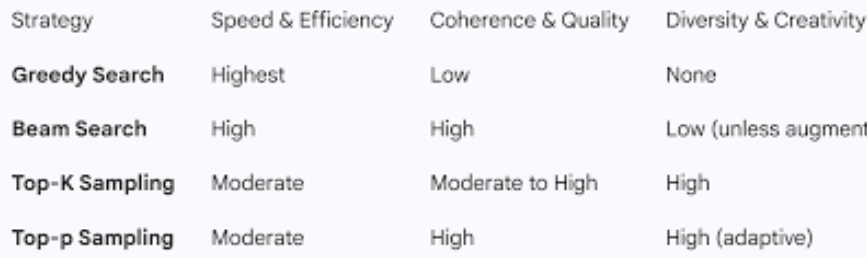

Use cases:
- If you want your model to perform a precise task like arithmetic or providing an answer to a specific question, then you should lower the temperature or use deterministic methods like greedy search in combination with beam search to guarantee getting the most likely answer.
- If you want the model to generate longer texts and even be a bit creative, then you should switch to a sampling methods and increase the temperature or use a mix of top-k and nucleus sampling.


**Greedy Decoding**
- The simplest decoding method to get discrete tokens from a model's continuous output;
- Greedily selects the token with the highest probability at each timestep.


**Beam Search Decoding** 
- This approach keeps track of the top-b most probable next tokens, where b is referred to as the number of beams or partial hypotheses.
- The next set of beams are chosen by considering all possible next-token extensions of the existing set and selecting the b most likely extensions
- Uses log probability to avoid underflow

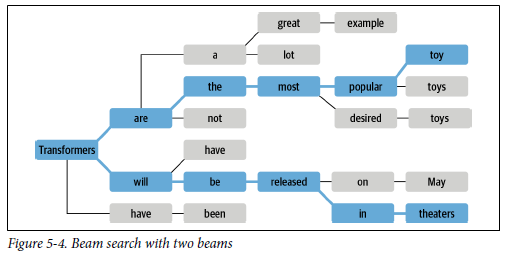


**Sampling methods**

- The simplest sampling method is to randomly sample from the probability distribution of the model's output over the full vocabulary at each timestep.
- Temperature parameter T: allows us to control the diversity of the output
  - $T << 1$, the distribution becomes peaked around the origin and the rare tokens are suppressed
  - $T >> 1$, the distribution flattens out and each token becomes equally likely
  - Temperature allows us to control the quality of the samples, but there is always a trade-off between coherence (low temperature) and diversity (high temperature)

**Top-k and Nucleus Sampling**

- Top-k and nucleus (top-p) sampling are two popular alternatives or extensions to using temperature
- In both cases, the basic idea is to restrict the number of possible tokens we can sample from at each timestep
  - Top-k sampling: avoid the low-probability choices by only sampling from the k tokens with the highest probability. The value of k is chosen manually 
  - Nucleus / top-p sampling: instead of choosing a fixed cutoff value, we set a condition of when to cut off - if we set the p to 95%, we order all tokens in descending order by probability and add one token after another from the top of the list until the sum of the probabilities of the selected tokens is 95%.


## LLM

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_name = 'gpt2-xl'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)


In [2]:
import pandas as pd

input_txt = 'Transformers are the'
input_ids = tokenizer(input_txt, return_tensors='pt')['input_ids'].to(device)
iterations = []
n_steps = 8
choices_per_step = 5

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration['Input'] = tokenizer.decode(input_ids[0])
        print(iteration)
        output = model(input_ids = input_ids)
        # Select logits of the first batch and the last token and apply softmax
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim = -1)
        sorted_ids = torch.argsort(next_token_probs, dim = -1, descending = True)
        # Store tokens with highest probabilities
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice
        # Append predicted next token to input
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim = -1)
        iterations.append(iteration)

pd.DataFrame(iterations)

{'Input': 'Transformers are the'}
{'Input': 'Transformers are the most'}
{'Input': 'Transformers are the most popular'}
{'Input': 'Transformers are the most popular toy'}
{'Input': 'Transformers are the most popular toy line'}
{'Input': 'Transformers are the most popular toy line in'}
{'Input': 'Transformers are the most popular toy line in the'}
{'Input': 'Transformers are the most popular toy line in the world'}


Input           Choice 1  \
0                               Transformers are the       most (8.53%)   
1                          Transformers are the most   popular (16.78%)   
2                  Transformers are the most popular       toy (10.63%)   
3              Transformers are the most popular toy      line (34.38%)   
4         Transformers are the most popular toy line        in (46.28%)   
5      Transformers are the most popular toy line in       the (65.99%)   
6  Transformers are the most popular toy line in the     world (69.26%)   
7  Transformers are the most popular toy line in ...         , (39.73%)   

            Choice 2               Choice 3               Choice 4  \
0       only (4.96%)           best (4.65%)   Transformers (4.37%)   
1   powerful (5.37%)         common (4.96%)         famous (3.72%)   
2       toys (7.23%)   Transformers (6.60%)             of (5.46%)   
3        in (18.20%)            of (11.71%)          brand (6.10%)   
4        of (15.09%)              , (4.94%)             on (4.40%)   
5   history (12.42%)        America (6.91%)          Japan (2.44%)   
6     United (4.55%)        history (4.29%)             US (4.23%)   
7         . (30.64%)            and (9.87%)           with (2.32%)   

              Choice 5  
0     ultimate (2.16%)  
1   successful (3.20%)  
2          and (3.76%)  
3         line (2.69%)  
4         ever (2.72%)  
5        North (1.40%)  
6            U (2.30%)  
7        today (1.74%)

In [3]:
input_ids = tokenizer(input_txt, return_tensors = 'pt')['input_ids'].to(device)
output = model.generate(input_ids, max_new_tokens = n_steps, do_sample = False)
print(tokenizer.decode(output[0]))



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Transformers are the most popular toy line in the world,


In [4]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors = 'pt')['input_ids'].to(device)
output_greedy = model.generate(input_ids,
                               max_length = max_length,
                               do_sample = False
                               )
print(tokenizer.decode(output_greedy[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, Davis, and the University of Colorado, Boulder, were conducting a study on the Andean cloud forest, which is home to the rare species of cloud forest trees.


The researchers were surprised to find that the unicorns were able to communicate with each other, and even with humans.


The researchers were surprised to find that the unicorns were able


In [5]:
import numpy as np

sum([np.log(0.5)] * 1024)

np.float64(-709.7827128933695)

In [6]:
import torch.nn.functional as F

def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim = -1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label

def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(
            output.logits[:, :-1, :], labels[:, 1:]
        )
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob.cpu().numpy()

# Greedy output
logp = sequence_logprob(model, output_greedy, input_len = len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\nlog-prob: {logp:.2f}")


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, Davis, and the University of Colorado, Boulder, were conducting a study on the Andean cloud forest, which is home to the rare species of cloud forest trees.


The researchers were surprised to find that the unicorns were able to communicate with each other, and even with humans.


The researchers were surprised to find that the unicorns were able

log-prob: -87.43


In [8]:
# Beam output
output_beam = model.generate(
    input_ids, 
    max_length = max_length, 
    num_beams=5, 
    do_sample = False,
    no_repeat_ngram_size = 2 # to prevent repetitive text from being generated
)
logp = sequence_logprob(model, output_beam, input_len = len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

AcceleratorError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# Chapter 6: Summarization

In [12]:
from datasets import load_dataset

dataset = load_dataset('cnn_dailymail', '3.0.0')
print(f"Features: {dataset['train'].column_names}")


Features: ['article', 'highlights', 'id']


In [13]:
sample = dataset['train'][1]
print(f"""
      Article (excerpt of 500 characters, total length: {len(sample['article'])}):
""")
print(sample['article'][:500])
print(f'\nSummary (length: {len(sample['highlights'])}):')
print(sample['highlights'])


      Article (excerpt of 500 characters, total length: 4051):

Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most s

Summary (length: 281):
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .


In [14]:
sample_text = dataset['train'][1]['article'][:2000]
# We'll collect the generated summaries of each model in a dictionary
summaries = {}


In [15]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\evgen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [16]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download('punkt')
string = 'The U.S. are a country. The U.N. is an organisation.'
sent_tokenize(string)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\evgen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['The U.S. are a country.', 'The U.N. is an organisation.']

In [17]:
def three_sentence_summary(text):
    return '\n'.join(sent_tokenize(text)[:3])

summaries['baseline'] = three_sentence_summary(sample_text)

In [18]:
from transformers import pipeline, set_seed

set_seed(42)
# # pipe = pipeline('text-generation', model='gpt2-xl') # doesn't work - too large
# pipe = pipeline('text-generation', model = 'gpt2')

# # count the number of parameters
# model = pipe.model
# num_params = sum(p.numel() for p in model.parameters())
# print(f"Number of parameters in the model: {num_params}")

# gpt2_query = sample_text + '\nTL;DR:\n'
# pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces= True)
# summaries['gpt2'] = '\n'.join(
#     sent_tokenize(pipe_out[0]['generated_text'][len(gpt2_query) :])
# )

In [ ]:
pipe = pipeline('summarization', model = 't5-large')
pipe_out = pipe(sample_text)
summaries['t5'] = '\n'.join(sent_tokenize(pipe_out[0]['summary_text']))


In [22]:
# pipe = pipeline('summarization', model = 'facebook/bart-large-cnn')
# pipe_out = pipe(sample_text)
# summaries['bart'] = '\n'.join(sent_tokenize(pipe_out[0]['summary_text']))

In [23]:
summaries

{'baseline': 'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.\nHere, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.\nMIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."',
 't5': "inmates with most severe mental illnesses are incarcerated until they're ready to appear in court .\nmost often, they face drug charges or charges of assaulting an officer .\nthey end up on the ninth floor severely mentally disturbed, but not getting real help ."}

# Chapter 7: Question Answering

In [4]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names(
    'subjqa',
    trust_remote_code = True
)
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [6]:
from datasets import load_dataset

subjqa = load_dataset('subjqa', name = 'electronics')

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


data.zip:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1295 [00:00<?, ? examples/s]

C:\Users\evgen\.cache\huggingface\modules\datasets_modules\datasets\subjqa\2c12e496c4c675ab4a57ffb5d3f538f2e7b89793956e50da37126393ce23b6c6\subjqa.py:189: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  if pd.unique(d["human_ans_spans"])[0] != "ANSWERNOTFOUND":
C:\Users\evgen\.cache\huggingface\modules\datasets_modules\datasets\subjqa\2c12e496c4c675ab4a57ffb5d3f538f2e7b89793956e50da37126393ce23b6c6\subjqa.py:189: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  if pd.unique(d["human_ans_spans"])[0] != "ANSWERNOTFOUND":
C:\Users\evgen\.cache\huggingface\modules\datasets_modules\datasets\subjqa\2c12e496c4c675ab4a57ffb5d3f538f2e7b89793956e50da37126393ce23b6c6\subjqa.py:189: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated an

Generating test split:   0%|          | 0/358 [00:00<?, ? examples/s]

C:\Users\evgen\.cache\huggingface\modules\datasets_modules\datasets\subjqa\2c12e496c4c675ab4a57ffb5d3f538f2e7b89793956e50da37126393ce23b6c6\subjqa.py:189: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  if pd.unique(d["human_ans_spans"])[0] != "ANSWERNOTFOUND":
C:\Users\evgen\.cache\huggingface\modules\datasets_modules\datasets\subjqa\2c12e496c4c675ab4a57ffb5d3f538f2e7b89793956e50da37126393ce23b6c6\subjqa.py:189: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  if pd.unique(d["human_ans_spans"])[0] != "ANSWERNOTFOUND":
C:\Users\evgen\.cache\huggingface\modules\datasets_modules\datasets\subjqa\2c12e496c4c675ab4a57ffb5d3f538f2e7b89793956e50da37126393ce23b6c6\subjqa.py:189: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated an

Generating validation split:   0%|          | 0/255 [00:00<?, ? examples/s]

C:\Users\evgen\.cache\huggingface\modules\datasets_modules\datasets\subjqa\2c12e496c4c675ab4a57ffb5d3f538f2e7b89793956e50da37126393ce23b6c6\subjqa.py:189: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  if pd.unique(d["human_ans_spans"])[0] != "ANSWERNOTFOUND":
C:\Users\evgen\.cache\huggingface\modules\datasets_modules\datasets\subjqa\2c12e496c4c675ab4a57ffb5d3f538f2e7b89793956e50da37126393ce23b6c6\subjqa.py:189: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  if pd.unique(d["human_ans_spans"])[0] != "ANSWERNOTFOUND":
C:\Users\evgen\.cache\huggingface\modules\datasets_modules\datasets\subjqa\2c12e496c4c675ab4a57ffb5d3f538f2e7b89793956e50da37126393ce23b6c6\subjqa.py:189: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated an

In [9]:
print(subjqa['train']['question'][1])


Is this music song have a goo bass?


In [7]:
print(subjqa['train']['answers'][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


In [14]:
subjqa.flatten().items()

dict_items([('train', Dataset({
    features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers.text', 'answers.answer_start', 'answers.answer_subj_level', 'answers.ans_subj_score', 'answers.is_ans_subjective'],
    num_rows: 1295
})), ('test', Dataset({
    features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers.text', 'answers.answer_start', 'answers.answer_subj_level', 'answers.ans_subj_score', 'answers.is_ans_subjective'],
    num_rows: 358
})), ('validation', Dataset({
    features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers.text', 'answ

In [10]:
dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}
dfs

{'train':            domain       nn_mod         nn_asp   query_mod   query_asp  \
 0     electronics        great  bass response   excellent        bass   
 1     electronics        harsh           high  not strong        bass   
 2     electronics      neutral          sound     present        bass   
 3     electronics        muddy           bass     awesome        bass   
 4     electronics      perfect           bass  incredible       sound   
 ...           ...          ...            ...         ...         ...   
 1290  electronics        great     impression     rubbery        feel   
 1291  electronics        tight           case       great  protection   
 1292  electronics         good        texture        good        grip   
 1293  electronics  easy to use       keyboard   removable    keyboard   
 1294  electronics  easy to use       keyboard   removable    keyboard   
 
                           q_reviews_id  question_subj_level  ques_subj_score  \
 0     0514ee34b6726

In [11]:
for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [17]:
dfs['train'].columns

Index(['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id',
       'question_subj_level', 'ques_subj_score', 'is_ques_subjective',
       'review_id', 'id', 'title', 'context', 'question', 'answers.text',
       'answers.answer_start', 'answers.answer_subj_level',
       'answers.ans_subj_score', 'answers.is_ans_subjective'],
      dtype='object')

In [16]:
dfs['train']

domain       nn_mod         nn_asp   query_mod   query_asp  \
0     electronics        great  bass response   excellent        bass   
1     electronics        harsh           high  not strong        bass   
2     electronics      neutral          sound     present        bass   
3     electronics        muddy           bass     awesome        bass   
4     electronics      perfect           bass  incredible       sound   
...           ...          ...            ...         ...         ...   
1290  electronics        great     impression     rubbery        feel   
1291  electronics        tight           case       great  protection   
1292  electronics         good        texture        good        grip   
1293  electronics  easy to use       keyboard   removable    keyboard   
1294  electronics  easy to use       keyboard   removable    keyboard   

                          q_reviews_id  question_subj_level  ques_subj_score  \
0     0514ee34b672623dff659334a25b599b                    5             0.50   
1     7c46670208f7bf5497480fbdbb44561a                    1             0.50   
2     8fbf26792c438aa83178c2d507af5d77                    1             0.50   
3     9876fd06ed8f075fcad70d1e30e7e8be                    1             0.50   
4     16506b53e2d4c2b6a65881d9462256c2                    1             0.65   
...                                ...                  ...              ...   
1290  d4409d6272a7d1d5aa287d6e164bb7d0                    1             0.00   
1291  ed6533390fe2fe0d546b69dea570c34b                    5             0.00   
1292  22b23446daf9d5bc0140be7278b220ee                    1             0.00   
1293  e7967ad5be0658b4acfca1118f6af1ab                    1             0.00   
1294  e7967ad5be0658b4acfca1118f6af1ab                    1             0.00   

      is_ques_subjective                         review_id  \
0                  False  882b1e2745a4779c8f17b3d4406b91c7   
1                  False  ce76793f036494eabe07b33a9a67288a   
2                  False  d040f2713caa2aff0ce95affb40e12c2   
3                  False  043e7162df91f6ea916c790c8a6f6b22   
4                   True  29ccd7e690050e2951be49289e915382   
...                  ...                               ...   
1290               False  ebaaec25661c0b21f3e5600a1ed7e30b   
1291               False  ebaaec25661c0b21f3e5600a1ed7e30b   
1292               False  84efbd9643d7f43af0ea0d2468c7dcc9   
1293               False  e856d7e5351e3385b5d75f06562e905b   
1294               False  57fa25acee9914487510f4a8ee37bca6   

                                    id       title  \
0     2543d296da9766d8d17d040ecc781699  B00001P4ZH   
1     d476830bf9282e2b9033e2bb44bbb995  B00001P4ZH   
2     455575557886d6dfeea5aa19577e5de4  B00001P4ZH   
3     6895a59b470d8feee0f39da6c53a92e5  B00001WRSJ   
4     7a2173c502da97c5bd5950eae7cd7430  B00001WRSJ   
...                                ...         ...   
1290  e0ea72e711324b5482ec1b36a48f16ee  B00H3OYSHW   
1291  ee5906ed3306b7c6d219a40adae2c7c2  B00H3OYSHW   
1292  a541ffd9697ebf0ad9d226428594128e  B00HNGB1YS   
1293  7efc5e7ffaa79f53cc50f76a44f9f88e  B00HPM1G8Q   
1294  4bfdd55cb76def0cbae0e0df5e7a14b6  B00HPM1G8Q   

                                                context  \
0     I have had Koss headphones in the past, Pro 4A...   
1     To anyone who hasn't tried all the various typ...   
2     I have had many sub-$100 headphones from $5 Pa...   
3     My sister's Bose headphones finally died and s...   
4     Wow. Just wow. I'm a 22 yr old with a crazy ob...   
...                                                 ...   
1290  I ordered my new NewTrend Airbender Pro NT610K...   
1291  I ordered my new NewTrend Airbender Pro NT610K...   
1292  After using this case for a few days, I have g...   
1293  Edit 4/21/14. I finally caved and purchased a ...   
1294  The Belkin QODE Portable Bluetooth Keyboard Ca...   

                                   question  \
0                      

In [23]:
import pandas as pd

In [24]:
pd.set_option('display.max_colwidth', None)

In [25]:
qa_cols = ['title', 'question', 'answers.text', 'answers.answer_start', 'context']
sample_df = dfs['train'][qa_cols].sample(2, random_state = 7)
sample_df

title                        question                answers.text  \
791   B005DKZTMG  Does the keyboard lightweight?  [this keyboard is compact]   
1159  B00AAIPT76             How is the battery?                          []   

     answers.answer_start  \
791                 [215]   
1159                   []   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  context  
791                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            I really like this keyboard.  I give it 4 stars because it doesn't have a CAPS LOCK key so I never know if my caps are on.  But for the price, it really suffices as a wireless keyboard.  I have very large hands and this keyboard is compact, but I have no complaints.  
1159  I bought this after the first spare gopro battery I bought wouldn't hold a charge. I have very realistic expectations of this sort of product, I am skeptical of amazing stories of charge time and battery life but I do expect the batteries to hold a charge for a couple of weeks at least and for the charger to work like a charger. In this I was not disappointed. I am a river rafter and found that the gopro burns through power in a hurry so this purchase solved that issue. the batteries held a charge, on shorter trips the extra two batteries were enough and on longer trips I could use my friends JOOS Orange to recharge them.I just bought a newtrent xtreme powerpak and expect to be able to charge these with that so I will not run out of power again.

In [26]:
start_idx = sample_df['answers.answer_start'].iloc[0][0]
start_idx

np.int32(215)

In [28]:
end_idx = start_idx + len(sample_df['answers.text'].iloc[0][0])
end_idx

np.int32(239)

In [31]:
sample_df['context'].iloc[0][start_idx : end_idx]

'this keyboard is compact'

In [39]:
dfs['train']['question'].str.startswith('When').value_counts()

question
False    1283
True       12
Name: count, dtype: int64

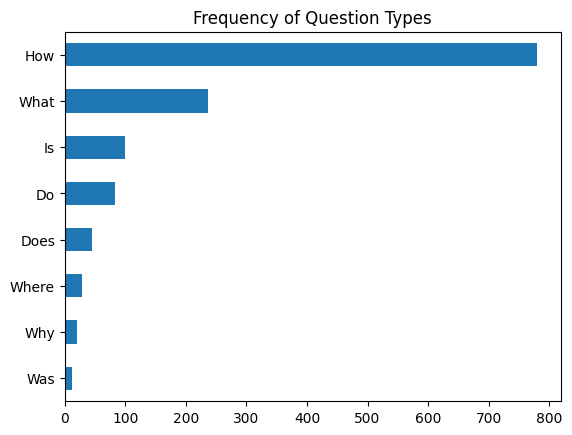

In [41]:
import matplotlib.pyplot as plt
counts = {}
question_types = {'What', 'How', 'Is', 'Does', 'Do', 'Was', 'Where', 'Why'}
for q in question_types:
    counts[q] = dfs['train']['question'].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title('Frequency of Question Types')
plt.show()

In [49]:
dfs['train'][dfs['train']['question'].str.startswith('How')].sample(3)['question'].values

array(['How is the video quality on the ACE monitor?', 'How is screen?',
       'How is it the expectation?'], dtype=object)

In [50]:
for question_type in ['How', 'What', 'Is']:
    questions = dfs['train'][
        dfs['train']['question'].str.startswith(question_type)
    ].sample(3)['question'].values
    for i in questions:
        print(i)

How is drive?
How is the reputation?
How is the configuration?
What is shot?
What about the tv?
What text do you prefer?
Is he a good driver?
Is a helpless camera?
Is this manual useful?
